## Бэггинг и случайный лес

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data; y = digits.target;

Для оценки качества далее нужно будет использовать cross_val_score из sklearn.model_selection с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Мы предлагаем использовать k=10, чтобы полученные оценки качества имели небольшой разброс, и было проще проверить полученные ответы. На практике же часто хватает и k=5. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

In [2]:
from sklearn.model_selection import cross_val_score
cv=10; k=cv;

**1.** Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score. 

In [3]:
from sklearn import metrics, tree 
estimator = tree.DecisionTreeClassifier()
print(cross_val_score(estimator, X, y, cv=k).mean())

0.825791013596


**2.** Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

In [4]:
from sklearn.ensemble import BaggingClassifier
estimator = BaggingClassifier(n_estimators=100)
print(cross_val_score(estimator, X, y,cv=10).mean())

0.923782435173


**3.** Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt d$ случайных признаков. 

In [5]:
X.shape[1]

64

In [6]:
import numpy as np
n_attributes = np.int(np.sqrt(X.shape[1]))
estimator = BaggingClassifier(n_estimators=100, max_features=n_attributes, random_state=1)
cross_val_score(estimator, X, y).mean()

0.92204375262652505

**4.** Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Попробуйте выбирать опять же $\sqrt d$ признаков. 

In [8]:
estimator = BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(splitter='random'),
                              n_estimators=100, max_features=n_attributes, random_state=1)
cross_val_score(estimator, X, y, cv=10).mean()

0.92593560568117983

**5.** Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble.

In [9]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier(n_estimators = 100, max_features=n_attributes, random_state = 1)
cross_val_score(estimator, X, y).mean()

0.9449015451626197

_**Изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.**_

In [14]:
trees = np.arange(1,51,4)
cvs_trees = list(map(lambda n_trees: cross_val_score(RandomForestClassifier(n_estimators = n_trees), 
                                                     X, y).mean(), trees))
features = np.arange(1,65,4)
cvs_features = list(map(lambda n_feat: cross_val_score(RandomForestClassifier(max_features = n_feat), 
                                                  X, y).mean(), features))
depths = np.arange(2,33,2)
cvs_depths = list(map(lambda depth: cross_val_score(RandomForestClassifier(max_depth = depth), 
                                               X, y).mean(), depths))

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


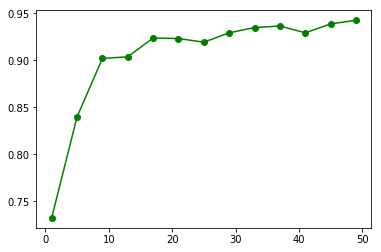

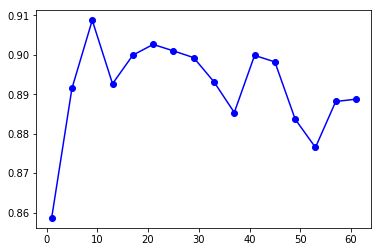

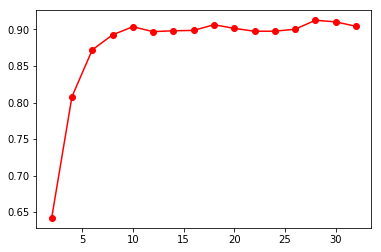

In [15]:
figure()
plot(trees, cvs_trees, '-g', marker='o')
figure()
plot(features, cvs_features, '-b', marker='o')
figure()
plot(depths, cvs_depths,'-r', marker='o')
plt.show()

In [17]:
depths

array([ 2,  4,  6,  8, 10, 12])

- _При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев_
- _С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется._
- _При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция._
- _При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга)._